In [1]:
import json
import os
import string
import time
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torchcrf import CRF
from seqeval.metrics import classification_report, f1_score as seq_f1_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch: {torch.__version__}')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

PyTorch: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.0 GB


### 1. KONFIGURASI

In [2]:
# Paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_RAW_DIR = os.path.join(BASE_DIR, 'data', 'raw')
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_DIR = os.path.join(BASE_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

BIEOS_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
POS_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_positive.tsv')
NEG_LEX_PATH = os.path.join(DATA_RAW_DIR, 'indonesian_sentiment_lexicon_negative.tsv')

# Model
MODEL_NAME = 'indobenchmark/indobert-large-p2'
MAX_LENGTH = 128
PROJ_DIM = 256

# Training
BATCH_SIZE = 4
GRADIENT_ACCUMULATION = 4  # effective batch = 16
NUM_EPOCHS = 15
LR_BERT = 2e-5
LR_HEAD = 1e-4
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 1.0
TRAIN_RATIO = 0.85
SEED = 42

# Architecture (Paper-aligned)
DROPOUT = 0.1
PHASE1_EPOCHS = 3           # SLD pre-training for Sentiment Connection
LAMBDA1 = 0.3               # Paper Eq. 10: weight for L_ae + L_sl
LAMBDA2 = 0.3               # Paper Eq. 10: weight for L_sd
MAX_REL_POS = 20            # Max relative position for cross-attention

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f'Model       : {MODEL_NAME}')
print(f'Batch size  : {BATCH_SIZE} x {GRADIENT_ACCUMULATION} accum = {BATCH_SIZE * GRADIENT_ACCUMULATION} effective')
print(f'Training    : Phase 1 ({PHASE1_EPOCHS} epochs) + Phase 2 ({NUM_EPOCHS} epochs)')
print(f'LR (BERT)   : {LR_BERT}')
print(f'LR (heads)  : {LR_HEAD}')
print(f'Loss weight : λ1={LAMBDA1}, λ2={LAMBDA2} (paper Eq. 10)')

Model       : indobenchmark/indobert-large-p2
Batch size  : 4 x 4 accum = 16 effective
Training    : Phase 1 (3 epochs) + Phase 2 (15 epochs)
LR (BERT)   : 2e-05
LR (heads)  : 0.0001
Loss weight : λ1=0.3, λ2=0.3 (paper Eq. 10)


### 2. LOAD DATA

In [3]:
# Load raw BIEOS data (original tokens + labels)
with open(BIEOS_PATH, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)
print(f'Total data: {len(raw_data)}')

# Load sentiment lexicon
def load_lexicon(path):
    words = set()
    with open(path, 'r', encoding='utf-8') as f:
        next(f)  # skip header
        for line in f:
            parts = line.strip().split('\t')
            if parts:
                word = parts[0].strip().lower()
                if ' ' not in word and len(word) > 1:  # single-word entries only
                    words.add(word)
    return words

pos_lexicon = load_lexicon(POS_LEX_PATH)
neg_lexicon = load_lexicon(NEG_LEX_PATH)

# Hapus kata yang muncul di kedua lexicon (ambigu)
overlap = pos_lexicon & neg_lexicon
pos_lexicon -= overlap
neg_lexicon -= overlap

print(f'Positive lexicon : {len(pos_lexicon)} words')
print(f'Negative lexicon : {len(neg_lexicon)} words')
print(f'Overlap removed  : {len(overlap)} words')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f'Tokenizer loaded : {MODEL_NAME}')

Total data: 2451
Positive lexicon : 2288 words
Negative lexicon : 5025 words
Overlap removed  : 1081 words
Tokenizer loaded : indobenchmark/indobert-large-p2


### 3. MULTI-TASK LABEL PREPARATION

| Task | Label Scheme | Jumlah |
|---|---|---|
| **ATE** (Aspect Term Extraction) | O, B, I, E, S | 5 |
| **SLD** (Sentiment Lexicon Detection) | O, POS, NEG | 3 |
| **ASD** (Aspect Sentiment Detection) | O, POS, NEG, NEU | 4 |
| **Final** (Aspect Polarity - CRF) | O, B/I/E/S-POS/NEG/NEU | 13 |

In [4]:
# Label schemes
ate_labels = ['O', 'B', 'I', 'E', 'S']
sld_labels = ['O', 'POS', 'NEG']
asd_labels = ['O', 'POS', 'NEG', 'NEU']
bieos_labels = ['O', 'B-NEG', 'B-NEU', 'B-POS', 'E-NEG', 'E-NEU', 'E-POS',
                'I-NEG', 'I-NEU', 'I-POS', 'S-NEG', 'S-NEU', 'S-POS']

ate_label2id = {l: i for i, l in enumerate(ate_labels)}
sld_label2id = {l: i for i, l in enumerate(sld_labels)}
asd_label2id = {l: i for i, l in enumerate(asd_labels)}
bieos_label2id = {l: i for i, l in enumerate(bieos_labels)}
bieos_id2label = {i: l for l, i in bieos_label2id.items()}

IGNORE_INDEX = -100

# --- Prior Embedding: word-level ATE frequency distribution (Paper Sec. 3.1.4) ---
word_ate_freq = {}
for d in raw_data:
    for tok, lab in zip(d['tokens'], d['labels']):
        tok_lower = tok.lower()
        if tok_lower not in word_ate_freq:
            word_ate_freq[tok_lower] = [0] * len(ate_labels)
        if lab == 'O':
            word_ate_freq[tok_lower][ate_label2id['O']] += 1
        else:
            prefix = lab.split('-')[0]
            word_ate_freq[tok_lower][ate_label2id[prefix]] += 1

default_prior = [1.0] + [0.0] * (len(ate_labels) - 1)
word_prior = {}
for word, counts in word_ate_freq.items():
    total = sum(counts)
    word_prior[word] = [c / total for c in counts] if total > 0 else default_prior

print(f'Prior vocabulary: {len(word_prior)} unique words')

# --- Prepare aligned labels for all 4 tasks + prior probs ---
all_input_ids = []
all_attention_mask = []
all_ate = []
all_sld = []
all_asd = []
all_bieos = []
all_crf = []
all_prior = []

for d in tqdm(raw_data, desc='Preparing labels'):
    tokens, labels = d['tokens'], d['labels']

    enc = tokenizer(tokens, is_split_into_words=True,
                    max_length=MAX_LENGTH, padding='max_length',
                    truncation=True, return_tensors='pt')
    word_ids = enc.word_ids(batch_index=0)

    ate_w, sld_w, asd_w = [], [], []
    for tok, lab in zip(tokens, labels):
        if lab == 'O':
            ate_w.append('O'); asd_w.append('O')
        else:
            prefix, sentiment = lab.split('-', 1)
            ate_w.append(prefix); asd_w.append(sentiment)

        t_clean = tok.lower().strip(string.punctuation)
        if t_clean in pos_lexicon:
            sld_w.append('POS')
        elif t_clean in neg_lexicon:
            sld_w.append('NEG')
        else:
            sld_w.append('O')

    ate_a, sld_a, asd_a, bieos_a, crf_a, prior_a = [], [], [], [], [], []
    prev_wid = None
    for wid in word_ids:
        if wid is None:
            ate_a.append(IGNORE_INDEX)
            sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX)
            bieos_a.append(IGNORE_INDEX)
            crf_a.append(0)
            prior_a.append(default_prior)
        elif wid != prev_wid:
            if wid < len(tokens):
                ate_a.append(ate_label2id[ate_w[wid]])
                sld_a.append(sld_label2id[sld_w[wid]])
                asd_a.append(asd_label2id[asd_w[wid]])
                bieos_a.append(bieos_label2id[labels[wid]])
                crf_a.append(bieos_label2id[labels[wid]])
                prior_a.append(word_prior.get(tokens[wid].lower(), default_prior))
            else:
                ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
                asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
                crf_a.append(0)
                prior_a.append(default_prior)
        else:
            ate_a.append(IGNORE_INDEX); sld_a.append(IGNORE_INDEX)
            asd_a.append(IGNORE_INDEX); bieos_a.append(IGNORE_INDEX)
            crf_a.append(bieos_label2id[labels[wid]] if wid < len(tokens) else 0)
            prior_a.append(word_prior.get(tokens[wid].lower(), default_prior) if wid < len(tokens) else default_prior)
        prev_wid = wid

    all_input_ids.append(enc['input_ids'].squeeze(0))
    all_attention_mask.append(enc['attention_mask'].squeeze(0))
    all_ate.append(torch.tensor(ate_a, dtype=torch.long))
    all_sld.append(torch.tensor(sld_a, dtype=torch.long))
    all_asd.append(torch.tensor(asd_a, dtype=torch.long))
    all_bieos.append(torch.tensor(bieos_a, dtype=torch.long))
    all_crf.append(torch.tensor(crf_a, dtype=torch.long))
    all_prior.append(torch.tensor(prior_a, dtype=torch.float))

data_dict = {
    'input_ids': torch.stack(all_input_ids),
    'attention_mask': torch.stack(all_attention_mask),
    'ate_labels': torch.stack(all_ate),
    'sld_labels': torch.stack(all_sld),
    'asd_labels': torch.stack(all_asd),
    'bieos_labels': torch.stack(all_bieos),
    'crf_labels': torch.stack(all_crf),
    'prior_probs': torch.stack(all_prior),
}

print('\nDataset shapes:')
for k, v in data_dict.items():
    print(f'  {k}: {v.shape}')

# Cek SLD coverage
sld_flat = data_dict['sld_labels'].flatten()
sld_valid = sld_flat[sld_flat != IGNORE_INDEX]
sld_counts = Counter(sld_valid.tolist())
print(f'\nSLD coverage:')
for lid, count in sorted(sld_counts.items()):
    print(f'  {sld_labels[lid]:4s}: {count}')

Prior vocabulary: 4682 unique words


Preparing labels:   0%|          | 0/2451 [00:00<?, ?it/s]


Dataset shapes:
  input_ids: torch.Size([2451, 128])
  attention_mask: torch.Size([2451, 128])
  ate_labels: torch.Size([2451, 128])
  sld_labels: torch.Size([2451, 128])
  asd_labels: torch.Size([2451, 128])
  bieos_labels: torch.Size([2451, 128])
  crf_labels: torch.Size([2451, 128])
  prior_probs: torch.Size([2451, 128, 5])

SLD coverage:
  O   : 39203
  POS : 6149
  NEG : 8348


### 4. DATASET & DATALOADER

In [5]:
class ABSAMultiTaskDataset(Dataset):
    def __init__(self, data_dict, indices):
        self.data = {k: v[indices] for k, v in data_dict.items()}

    def __len__(self):
        return self.data['input_ids'].size(0)

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}

# Train/Val split
total = len(raw_data)
indices = torch.randperm(total, generator=torch.Generator().manual_seed(SEED))
split = int(total * TRAIN_RATIO)

train_dataset = ABSAMultiTaskDataset(data_dict, indices[:split])
val_dataset = ABSAMultiTaskDataset(data_dict, indices[split:])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE * 2)

print(f'Train: {len(train_dataset)} ({TRAIN_RATIO*100:.0f}%)')
print(f'Val  : {len(val_dataset)} ({(1-TRAIN_RATIO)*100:.0f}%)')
print(f'Train batches: {len(train_loader)}')

Train: 2083 (85%)
Val  : 368 (15%)
Train batches: 521


### 5. MODEL ARCHITECTURE (Paper-aligned)

Sesuai Wang et al. (2021), adaptasi: IndoBERT menggantikan BiLSTM sebagai encoder.

```
IndoBERT (shared encoder, all layers trainable)
        |
        h
       / \
  [h;prior] h
      |      |
    h_ae   h_sl
     |       |
  ATE cls  SLD cls         ← CE loss (λ1=0.3)
     |       |
  CrossAttn(h_ae → h_sl)   ← Paper Eq. 7-9 (with position encoding)
        |
       h_sd
        |
     ASD cls                ← CE loss (λ2=0.3)
        |
  [h_ae ; h_sd]
        |
      CRF                   ← NLL loss (λ=1.0)
```

In [6]:
class CrossAttentionASD(nn.Module):
    """Paper Eq. 7-9: Cross-attention from ATE to SLD with relative position encoding."""

    def __init__(self, dim, max_relative_position=20):
        super().__init__()
        self.max_rel_pos = max_relative_position
        self.pos_embedding = nn.Embedding(2 * max_relative_position + 1, dim)
        self.W_ae = nn.Linear(dim, dim, bias=False)
        self.W_sl = nn.Linear(dim, dim, bias=False)
        self.W_pos = nn.Linear(dim, dim, bias=False)
        self.bias = nn.Parameter(torch.zeros(dim))
        self.w_s = nn.Linear(dim, 1, bias=False)

    def forward(self, h_ae, h_sl, mask=None):
        batch, seq_len, dim = h_ae.shape
        pos = torch.arange(seq_len, device=h_ae.device)
        rel_pos = (pos.unsqueeze(0) - pos.unsqueeze(1)).clamp(
            -self.max_rel_pos, self.max_rel_pos) + self.max_rel_pos
        p_ij = self.pos_embedding(rel_pos)

        s_ae = self.W_ae(h_ae)
        s_sl = self.W_sl(h_sl)
        s_pos = self.W_pos(p_ij)

        combined = s_ae.unsqueeze(2) + s_sl.unsqueeze(1) + s_pos.unsqueeze(0) + self.bias
        scores = self.w_s(torch.tanh(combined)).squeeze(-1)

        if mask is not None:
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))

        attn_weights = torch.softmax(scores, dim=-1)
        h_sd = torch.bmm(attn_weights, h_sl)
        return h_sd


class HierarchicalMultiTaskABSA(nn.Module):
    def __init__(self, model_name, num_ate, num_sld, num_asd, num_final,
                 proj_dim=256, dropout=0.1, asd_weights=None,
                 max_relative_position=20, lambda1=0.3, lambda2=0.3):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.num_sld = num_sld
        self.num_asd = num_asd

        self.bert = AutoModel.from_pretrained(model_name, use_safetensors=True, low_cpu_mem_usage=True)
        bert_dim = self.bert.config.hidden_size

        # Task 1: ATE with Prior Embedding
        self.ate_proj = nn.Sequential(
            nn.Linear(bert_dim + num_ate, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.ate_classifier = nn.Linear(proj_dim, num_ate)

        # Task 2: SLD
        self.sld_proj = nn.Sequential(
            nn.Linear(bert_dim, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.sld_classifier = nn.Linear(proj_dim, num_sld)

        # Task 3: ASD with Cross-Attention (Paper Eq. 7-9)
        self.cross_attention = CrossAttentionASD(proj_dim, max_relative_position)
        self.asd_classifier = nn.Linear(proj_dim, num_asd)

        # Task 4: CRF
        self.final_proj = nn.Sequential(
            nn.Linear(proj_dim * 2, proj_dim), nn.GELU(), nn.Dropout(dropout))
        self.final_emission = nn.Linear(proj_dim, num_final)
        self.crf = CRF(num_final, batch_first=True)

        self.dropout = nn.Dropout(dropout)
        self.asd_weights = asd_weights

    def forward(self, input_ids, attention_mask, prior_probs=None,
                ate_labels=None, sld_labels=None, asd_labels=None, crf_labels=None, **kwargs):
        h = self.dropout(self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state)

        # Task 1: ATE with Prior Embedding
        if prior_probs is not None:
            h_with_prior = torch.cat([h, prior_probs], dim=-1)
        else:
            h_with_prior = torch.cat([h, torch.zeros(*h.shape[:-1], self.ate_classifier.out_features, device=h.device)], dim=-1)
        h_ae = self.ate_proj(h_with_prior)
        ate_logits = self.ate_classifier(h_ae)

        # Task 2: SLD
        h_sl = self.sld_proj(h)
        sld_logits = self.sld_classifier(h_sl)

        # Task 3: ASD — Cross-Attention (h_ae → h_sl)
        mask = attention_mask.bool()
        h_sd = self.cross_attention(h_ae, h_sl, mask=mask)
        asd_logits = self.asd_classifier(h_sd)

        # Task 4: CRF
        h_concat = torch.cat([h_ae, h_sd], dim=-1)
        emissions = self.final_emission(self.final_proj(h_concat))

        outputs = {'ate_logits': ate_logits, 'sld_logits': sld_logits,
                   'asd_logits': asd_logits, 'emissions': emissions}

        if ate_labels is not None:
            ce = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
            loss_ate = ce(ate_logits.view(-1, ate_logits.size(-1)), ate_labels.view(-1))
            loss_sld = ce(sld_logits.view(-1, sld_logits.size(-1)), sld_labels.view(-1))

            ce_asd = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX,
                                          weight=self.asd_weights) if self.asd_weights is not None else ce
            loss_asd = ce_asd(asd_logits.view(-1, asd_logits.size(-1)), asd_labels.view(-1))

            loss_crf = -self.crf(emissions.float(), crf_labels, mask=mask, reduction='mean')

            # Paper Eq. 10: L = λ1*(L_ae + L_sl) + λ2*L_sd + L_co
            outputs['loss'] = self.lambda1 * (loss_ate + loss_sld) + self.lambda2 * loss_asd + loss_crf
            outputs['losses'] = {
                'ate': loss_ate.detach(), 'sld': loss_sld.detach(),
                'asd': loss_asd.detach(), 'crf': loss_crf.detach()}

        return outputs

    def decode(self, emissions, attention_mask):
        return self.crf.decode(emissions.float(), mask=attention_mask.bool())

    def apply_sentiment_connection(self):
        """Copy SLD classifier weights to ASD classifier (Paper Sec. 3.1.5)."""
        with torch.no_grad():
            n_copy = min(self.num_sld, self.num_asd)
            self.asd_classifier.weight.data[:n_copy].copy_(self.sld_classifier.weight.data[:n_copy])
            self.asd_classifier.bias.data[:n_copy].copy_(self.sld_classifier.bias.data[:n_copy])
        print(f'Sentiment Connection: copied SLD -> ASD weights (classes 0-{n_copy-1}: O, POS, NEG)')

In [7]:
model = HierarchicalMultiTaskABSA(
    model_name=MODEL_NAME,
    num_ate=len(ate_labels),
    num_sld=len(sld_labels),
    num_asd=len(asd_labels),
    num_final=len(bieos_labels),
    proj_dim=PROJ_DIM,
    dropout=DROPOUT,
    max_relative_position=MAX_REL_POS,
    lambda1=LAMBDA1,
    lambda2=LAMBDA2,
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters    : {total_params:,}')
print(f'Trainable parameters: {trainable:,}')
print(f'BERT hidden size    : {model.bert.config.hidden_size}')
print(f'Cross-Attention ASD : {sum(p.numel() for p in model.cross_attention.parameters()):,} params')

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Total parameters    : 336,013,532
Trainable parameters: 336,013,532
BERT hidden size    : 1024
Cross-Attention ASD : 207,616 params


### 6. TRAINING (Two-Phase + Sentiment Connection)

- **Phase 1** (3 epochs): Pre-training — semua task aktif, SLD classifier dilatih
- **Sentiment Connection**: Copy SLD classifier weights → ASD classifier
- **Phase 2** (15 epochs): Main training — baseline (no early stopping, no freeze, no class weights)

In [8]:
def evaluate(model, dataloader, device, desc='Evaluating'):
    """Evaluate model: compute loss + entity-level F1 from CRF predictions."""
    model.eval()
    total_loss = 0
    all_preds, all_true = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            total_loss += outputs['loss'].item()

            # CRF decode
            preds = model.decode(outputs['emissions'], batch['attention_mask'])
            bieos_lbl = batch['bieos_labels']

            # Ambil hanya posisi first-subword (bieos_labels != -100)
            for i in range(len(preds)):
                pred_seq, true_seq = [], []
                for j in range(len(preds[i])):
                    if bieos_lbl[i][j].item() != IGNORE_INDEX:
                        pred_seq.append(bieos_id2label[preds[i][j]])
                        true_seq.append(bieos_id2label[bieos_lbl[i][j].item()])
                all_preds.append(pred_seq)
                all_true.append(true_seq)

    avg_loss = total_loss / len(dataloader)
    f1 = seq_f1_score(all_true, all_preds)
    return avg_loss, f1, all_true, all_preds

In [9]:
# Optimizer: different LR for BERT vs task heads
bert_params = list(model.bert.named_parameters())
head_params = [(n, p) for n, p in model.named_parameters() if not n.startswith('bert')]

total_training_epochs = PHASE1_EPOCHS + NUM_EPOCHS
total_steps = (len(train_loader) // GRADIENT_ACCUMULATION) * total_training_epochs
warmup_steps = int(total_steps * WARMUP_RATIO)

optimizer = torch.optim.AdamW([
    {'params': [p for _, p in bert_params], 'lr': LR_BERT},
    {'params': [p for _, p in head_params], 'lr': LR_HEAD},
], weight_decay=WEIGHT_DECAY)

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

print(f'Total steps (P1+P2) : {total_steps}')
print(f'Warmup steps        : {warmup_steps}')

# Training history
history = {'train_loss': [], 'val_loss': [], 'val_f1': [],
           'loss_ate': [], 'loss_sld': [], 'loss_asd': [], 'loss_crf': []}

def train_one_epoch(model, train_loader, optimizer, scheduler, device, epoch_str):
    model.train()
    epoch_loss = 0
    epoch_comp = {'ate': 0, 'sld': 0, 'asd': 0, 'crf': 0}
    optimizer.zero_grad()
    t0 = time.time()

    step_bar = tqdm(train_loader, desc=epoch_str, leave=False, unit='batch')
    for step, batch in enumerate(step_bar):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss'] / GRADIENT_ACCUMULATION
        loss.backward()

        if (step + 1) % GRADIENT_ACCUMULATION == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        epoch_loss += outputs['loss'].item()
        for k in epoch_comp:
            epoch_comp[k] += outputs['losses'][k].item()
        step_bar.set_postfix(loss=f"{epoch_loss/(step+1):.3f}")

    n = len(train_loader)
    return epoch_loss / n, {k: v / n for k, v in epoch_comp.items()}, time.time() - t0

# =============================================
# PHASE 1: Pre-training (for Sentiment Connection)
# =============================================
print('=' * 60)
print(f'PHASE 1: Pre-training ({PHASE1_EPOCHS} epochs)')
print('=' * 60)

for epoch in range(PHASE1_EPOCHS):
    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    tqdm.write(
        f'P1 Epoch {epoch+1}/{PHASE1_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | F1: {val_f1:.4f}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

# =============================================
# SENTIMENT CONNECTION: Copy SLD → ASD
# =============================================
print('\n' + '=' * 60)
print('Applying Sentiment Connection')
print('=' * 60)
model.apply_sentiment_connection()

# =============================================
# PHASE 2: Main Training (Baseline — no early stopping)
# =============================================
print('\n' + '=' * 60)
print(f'PHASE 2: Main Training ({NUM_EPOCHS} epochs)')
print('=' * 60)

best_f1 = 0

for epoch in range(NUM_EPOCHS):
    global_epoch = PHASE1_EPOCHS + epoch + 1

    avg_train, comp, elapsed = train_one_epoch(
        model, train_loader, optimizer, scheduler, device,
        f'Epoch {global_epoch}/{PHASE1_EPOCHS + NUM_EPOCHS}')

    val_loss, val_f1, _, _ = evaluate(model, val_loader, device, desc='Validating')

    history['train_loss'].append(avg_train)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    for k in comp:
        history[f'loss_{k}'].append(comp[k])

    improved = val_f1 > best_f1
    if improved:
        best_f1 = val_f1
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_model.pt'))

    tqdm.write(
        f'Epoch {global_epoch:2d}/{PHASE1_EPOCHS + NUM_EPOCHS} | {elapsed:.0f}s | '
        f'Train: {avg_train:.4f} | Val: {val_loss:.4f} | '
        f'F1: {val_f1:.4f} {"*" if improved else ""}\n'
        f'  ATE:{comp["ate"]:.3f}  SLD:{comp["sld"]:.3f}  '
        f'ASD:{comp["asd"]:.3f}  CRF:{comp["crf"]:.3f}')

actual_epochs = len(history['train_loss'])
print(f'\nTraining finished after {actual_epochs} epochs')
print(f'  Phase 1: {PHASE1_EPOCHS} epochs (SLD pre-training)')
print(f'  Phase 2: {NUM_EPOCHS} epochs (main training)')
print(f'Best Val F1: {best_f1:.4f}')

Total steps (P1+P2) : 2340
Warmup steps        : 234
PHASE 1: Pre-training (3 epochs)


P1 Epoch 1/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 1/3 | 253s | Train: 36.4952 | Val: 15.0515 | F1: 0.0000
  ATE:1.046  SLD:0.906  ASD:1.147  CRF:35.566


P1 Epoch 2/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 2/3 | 257s | Train: 12.2575 | Val: 8.7031 | F1: 0.5550
  ATE:0.440  SLD:0.772  ASD:0.579  CRF:11.720


P1 Epoch 3/3:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

P1 Epoch 3/3 | 252s | Train: 7.2116 | Val: 6.9394 | F1: 0.6525
  ATE:0.271  SLD:0.755  ASD:0.471  CRF:6.763

Applying Sentiment Connection
Sentiment Connection: copied SLD -> ASD weights (classes 0-2: O, POS, NEG)

PHASE 2: Main Training (15 epochs)


Epoch 4/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  4/18 | 261s | Train: 4.2817 | Val: 7.1331 | F1: 0.7086 *
  ATE:0.180  SLD:0.737  ASD:0.484  CRF:3.862


Epoch 5/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  5/18 | 258s | Train: 2.5636 | Val: 8.3852 | F1: 0.7155 *
  ATE:0.123  SLD:0.738  ASD:0.379  CRF:2.192


Epoch 6/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  6/18 | 260s | Train: 1.7261 | Val: 8.1815 | F1: 0.7406 *
  ATE:0.092  SLD:0.715  ASD:0.320  CRF:1.388


Epoch 7/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  7/18 | 260s | Train: 1.2171 | Val: 9.4859 | F1: 0.7325 
  ATE:0.071  SLD:0.690  ASD:0.250  CRF:0.914


Epoch 8/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  8/18 | 254s | Train: 0.8653 | Val: 9.8453 | F1: 0.7390 
  ATE:0.052  SLD:0.652  ASD:0.150  CRF:0.609


Epoch 9/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch  9/18 | 256s | Train: 0.6717 | Val: 11.5350 | F1: 0.7230 
  ATE:0.042  SLD:0.618  ASD:0.088  CRF:0.447


Epoch 10/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/18 | 256s | Train: 0.4991 | Val: 11.9190 | F1: 0.7198 
  ATE:0.032  SLD:0.569  ASD:0.057  CRF:0.302


Epoch 11/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/18 | 262s | Train: 0.3721 | Val: 13.1247 | F1: 0.7267 
  ATE:0.023  SLD:0.518  ASD:0.044  CRF:0.197


Epoch 12/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/18 | 256s | Train: 0.3066 | Val: 13.8402 | F1: 0.7266 
  ATE:0.017  SLD:0.457  ASD:0.034  CRF:0.154


Epoch 13/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/18 | 257s | Train: 0.2322 | Val: 13.8303 | F1: 0.7257 
  ATE:0.012  SLD:0.392  ASD:0.026  CRF:0.103


Epoch 14/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/18 | 257s | Train: 0.1715 | Val: 14.8196 | F1: 0.7410 *
  ATE:0.009  SLD:0.325  ASD:0.023  CRF:0.065


Epoch 15/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/18 | 253s | Train: 0.1470 | Val: 14.7986 | F1: 0.7330 
  ATE:0.007  SLD:0.274  ASD:0.019  CRF:0.057


Epoch 16/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/18 | 255s | Train: 0.1107 | Val: 15.1450 | F1: 0.7371 
  ATE:0.006  SLD:0.232  ASD:0.016  CRF:0.034


Epoch 17/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/18 | 257s | Train: 0.1057 | Val: 14.8297 | F1: 0.7389 
  ATE:0.006  SLD:0.209  ASD:0.015  CRF:0.037


Epoch 18/18:   0%|          | 0/521 [00:00<?, ?batch/s]

Validating:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/18 | 257s | Train: 0.0965 | Val: 14.9263 | F1: 0.7376 
  ATE:0.005  SLD:0.194  ASD:0.016  CRF:0.032

Training finished after 18 epochs
  Phase 1: 3 epochs (SLD pre-training)
  Phase 2: 15 epochs (main training)
Best Val F1: 0.7410


### 7. VISUALISASI TRAINING

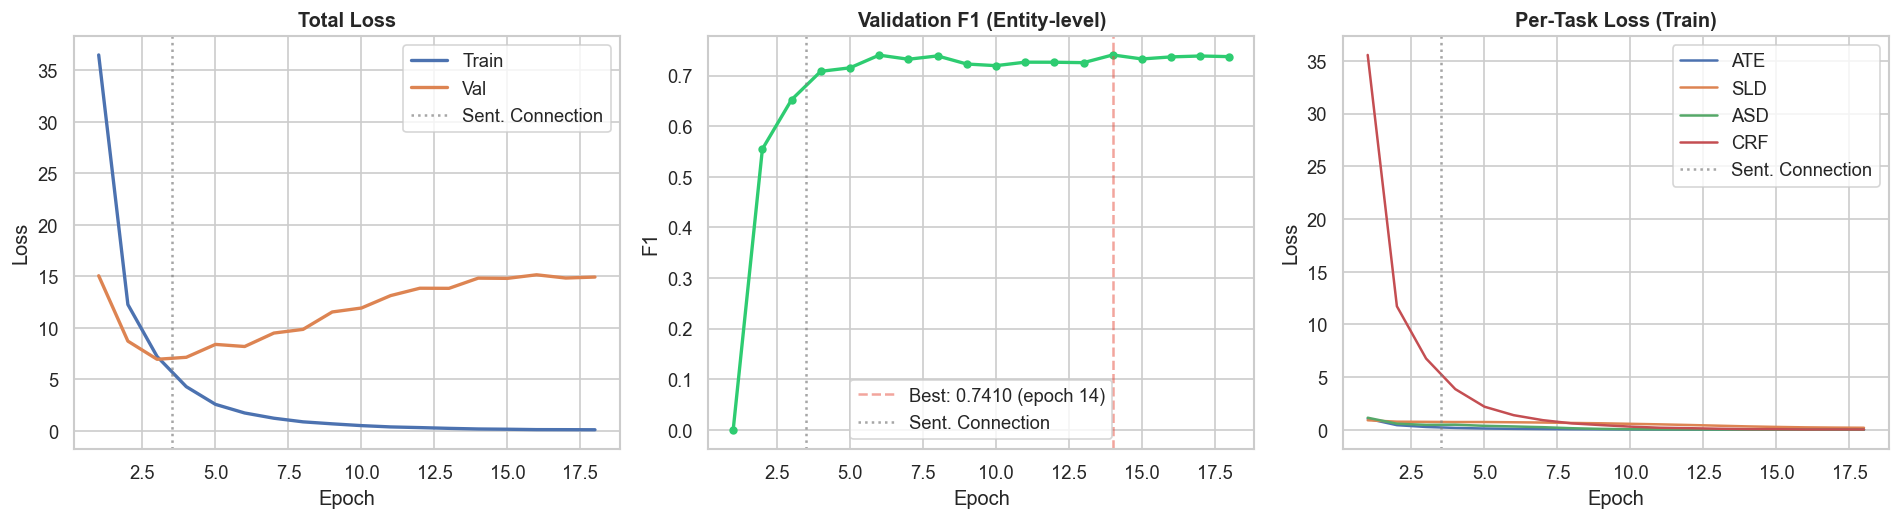

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], label='Val', linewidth=2)
axes[0].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[0].set_title('Total Loss', fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend()

# F1 curve
axes[1].plot(epochs_range, history['val_f1'], color='#2ecc71', linewidth=2, marker='o', markersize=4)
best_epoch = history['val_f1'].index(max(history['val_f1'])) + 1
axes[1].axvline(best_epoch, color='#e74c3c', linestyle='--', alpha=0.5,
                label=f'Best: {max(history["val_f1"]):.4f} (epoch {best_epoch})')
axes[1].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[1].set_title('Validation F1 (Entity-level)', fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('F1')
axes[1].legend()

# Per-task loss
for task in ['ate', 'sld', 'asd', 'crf']:
    axes[2].plot(epochs_range, history[f'loss_{task}'], label=task.upper(), linewidth=1.5)
axes[2].axvline(PHASE1_EPOCHS + 0.5, color='gray', linestyle=':', alpha=0.7, label='Sent. Connection')
axes[2].set_title('Per-Task Loss (Train)', fontweight='bold')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()
plt.show()

### 8. EVALUASI FINAL

In [11]:
# Load best model
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'best_model.pt'), weights_only=True))
val_loss, val_f1, all_true, all_preds = evaluate(model, val_loader, device)

print(f'Best Model - Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')
print(f'\n{classification_report(all_true, all_preds)}')

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Best Model - Val Loss: 14.8196, Val F1: 0.7410

              precision    recall  f1-score   support

         NEG       0.58      0.59      0.59        83
         NEU       0.54      0.66      0.59       125
         POS       0.77      0.83      0.80       536

   micro avg       0.71      0.77      0.74       744
   macro avg       0.63      0.69      0.66       744
weighted avg       0.71      0.77      0.74       744



### 9. SIMPAN MODEL & CONFIG

In [12]:
# Save complete checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'max_length': MAX_LENGTH,
    'proj_dim': PROJ_DIM,
    'dropout': DROPOUT,
    'bieos_label2id': bieos_label2id,
    'bieos_id2label': bieos_id2label,
    'ate_labels': ate_labels,
    'sld_labels': sld_labels,
    'asd_labels': asd_labels,
    'best_f1': best_f1,
    'history': history,
    'val_true': all_true,
    'val_preds': all_preds,
    'config': {
        'architecture': 'Paper-aligned (cross-attention, prior embedding, sentiment connection)',
        'dropout': DROPOUT,
        'weight_decay': WEIGHT_DECAY,
        'freeze_layers': '0/24 (all trainable)',
        'early_stopping': 'none',
        'asd_class_weights': 'none',
        'lambda1': LAMBDA1,
        'lambda2': LAMBDA2,
        'phase1_epochs': PHASE1_EPOCHS,
    }
}

save_path = os.path.join(MODEL_DIR, 'checkpoint_final.pt')
torch.save(checkpoint, save_path)

file_size = os.path.getsize(save_path) / (1024**2)
print(f'Checkpoint saved: {save_path}')
print(f'File size: {file_size:.1f} MB')
print(f'Best F1: {best_f1:.4f}')

Checkpoint saved: d:\Kuliah\TA\Notebook\models\checkpoint_final.pt
File size: 1282.0 MB
Best F1: 0.7410
